In [ ]:
pip install sentence-transformers

In [ ]:
pip install accelerate

In [ ]:
pip install torch

In [ ]:
pip install --upgrade sentence-transformers accelerate

In [20]:
import time
import torch
import random
import datetime
import numpy as np
import pandas as pd

from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer, models

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [3]:
dataset = load_dataset("stsb_multi_mt", "en")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 5749
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 1379
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 1500
    })
})


In [4]:
print("A sample from the dataset's training split:")
print(dataset['train'][98])

A sample from the dataset's training split:
{'sentence1': 'A man is slicing potatoes.', 'sentence2': 'A woman is peeling potato.', 'similarity_score': 2.200000047683716}


In [5]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
/home/vladimir.vincan.ivi/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
class STSBDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):
        # Normalize the similarity scores in the dataset
        similarity_scores = [i['similarity_score'] for i in dataset]
        self.normalized_similarity_scores = [i/5.0 for i in similarity_scores]
        self.first_sentences = [i['sentence1'] for i in dataset]
        self.second_sentences = [i['sentence2'] for i in dataset]
        self.concatenated_sentences = [[str(x), str(y)] for x,y in   zip(self.first_sentences, self.second_sentences)]

    def __len__(self):
        return len(self.concatenated_sentences)

    def get_batch_labels(self, idx):
        return torch.tensor(self.normalized_similarity_scores[idx])

    def get_batch_texts(self, idx):
        return tokenizer(self.concatenated_sentences[idx], padding='max_length', max_length=128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


def collate_fn(texts):
    input_ids = texts['input_ids']
    attention_masks = texts['attention_mask']
    features = [{'input_ids': input_id, 'attention_mask': attention_mask}
                for input_id, attention_mask in zip(input_ids, attention_masks)]
    return features

In [7]:
class BertForSTS(torch.nn.Module):

    def __init__(self):
        super(BertForSTS, self).__init__()
        self.bert = models.Transformer('distilbert-base-uncased', max_seq_length=64)
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = SentenceTransformer(modules=[self.bert, self.pooling_layer])

    def forward(self, input_data):
        output = self.sts_bert(input_data)['sentence_embedding']
        return output

In [8]:
# Instantiate the model and move it to GPU
model = BertForSTS()
model.to(device)
torch.cuda.empty_cache()

In [10]:
class CosineSimilarityLoss(torch.nn.Module):

    def __init__(self,  loss_fn=torch.nn.MSELoss(), transform_fn=torch.nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fn = loss_fn
        self.transform_fn = transform_fn
        self.cos_similarity = torch.nn.CosineSimilarity(dim=1)

    def forward(self, inputs, labels):
        emb_1 = torch.stack([inp[0] for inp in inputs])
        emb_2 = torch.stack([inp[1] for inp in inputs])
        outputs = self.transform_fn(self.cos_similarity(emb_1, emb_2))
        return self.loss_fn(outputs, labels.squeeze())

In [11]:
train_ds = STSBDataset(dataset['train'])
val_ds = STSBDataset(dataset['dev'])

# Create a 90-10 train-validation split.
train_size = len(train_ds)
val_size = len(val_ds)

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

5749 training samples
1500 validation samples


In [12]:
batch_size = 256

train_dataloader = DataLoader(
            train_ds,  # The training samples.
            num_workers = 4,
            batch_size = batch_size, # Use this batch size.
            shuffle=True # Select samples randomly for each batch
        )

validation_dataloader = DataLoader(
            val_ds,
            num_workers = 4,
            batch_size = batch_size # Use the same batch size
        )

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)
epochs = 150
# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
criterion=CosineSimilarityLoss()

In [14]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [15]:
def train_epoch(model, train_dataloader, optimizer, scheduler, criterion, device, collate_fn):
    """
    Runs one epoch of training.
    """
    total_train_loss = 0
    model.train()

    for train_data, train_label in tqdm(train_dataloader):
        train_data['input_ids'] = train_data['input_ids'].to(device)
        train_data['attention_mask'] = train_data['attention_mask'].to(device)
        train_data = collate_fn(train_data)

        model.zero_grad()

        # Get model output
        output = [model(feature) for feature in train_data]

        # Calculate loss
        loss = criterion(output, train_label.to(device))
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and learning rate
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    return avg_train_loss


def validate_epoch(model, validation_dataloader, criterion, device, collate_fn):
    """
    Runs one epoch of validation.
    """
    total_eval_loss = 0
    model.eval()

    for val_data, val_label in tqdm(validation_dataloader):
        val_data['input_ids'] = val_data['input_ids'].to(device)
        val_data['attention_mask'] = val_data['attention_mask'].to(device)
        val_data = collate_fn(val_data)

        with torch.no_grad():
            output = [model(feature) for feature in val_data]

        # Calculate loss
        loss = criterion(output, val_label.to(device))
        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    return avg_val_loss

In [16]:
def train(model, train_dataloader, validation_dataloader, optimizer, scheduler, criterion, device, collate_fn, epochs, patience=5, min_delta=0.0001):
    """
    Combines training and validation over multiple epochs, with early stopping.
    """
    seed_val = 42
    random.seed(seed_val)
    torch.manual_seed(seed_val)

    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    training_stats = []

    for epoch_i in range(0, epochs):
        print(f"Epoch {epoch_i + 1}/{epochs}")

        # Train for one epoch
        avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, criterion, device, collate_fn)

        # Validation for one epoch
        avg_val_loss = validate_epoch(model, validation_dataloader, criterion, device, collate_fn)

        # Record all statistics from this epoch
        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
        })

        print(f"Training Loss: {avg_train_loss:.3f}")
        print(f"Validation Loss: {avg_val_loss:.3f}")

        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    # Plot training and validation loss
    epochs = [stat['epoch'] for stat in training_stats]
    train_losses = [stat['Training Loss'] for stat in training_stats]
    val_losses = [stat['Validation Loss'] for stat in training_stats]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', linestyle='-')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(ticks=epochs[::5])
    plt.legend()
    plt.grid()
    plt.show()

    return model, training_stats

In [17]:
def save_bert_model(model, model_weights_filename='bert_model_weights.pth'):
    """
    Saves the BERT model's state dictionary.

    Args:
        model (torch.nn.Module): The BERT model to save.
        model_weights_filename (str): Filename to save the model weights. Defaults to 'bert_model_weights.pth'.
    """
    # Save model weights
    torch.save(model.state_dict(), model_weights_filename)
    print(f"Model weights saved as {model_weights_filename}")

Epoch 1/150


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Loss: 0.180
Validation Loss: 0.205
Epoch 2/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.163
Validation Loss: 0.185
Epoch 3/150


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Training Loss: 0.145
Validation Loss: 0.165
Epoch 4/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.129
Validation Loss: 0.147
Epoch 5/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.115
Validation Loss: 0.132
Epoch 6/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.103
Validation Loss: 0.118
Epoch 7/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.092
Validation Loss: 0.107
Epoch 8/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.083
Validation Loss: 0.097
Epoch 9/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.074
Validation Loss: 0.089
Epoch 10/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.068
Validation Loss: 0.082
Epoch 11/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.062
Validation Loss: 0.076
Epoch 12/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.058
Validation Loss: 0.072
Epoch 13/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.054
Validation Loss: 0.068
Epoch 14/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.051
Validation Loss: 0.064
Epoch 15/150


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Training Loss: 0.048
Validation Loss: 0.061
Epoch 16/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.046
Validation Loss: 0.059
Epoch 17/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.044
Validation Loss: 0.057
Epoch 18/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.043
Validation Loss: 0.055
Epoch 19/150


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Training Loss: 0.041
Validation Loss: 0.053
Epoch 20/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.039
Validation Loss: 0.052
Epoch 21/150


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Training Loss: 0.039
Validation Loss: 0.051
Epoch 22/150


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Training Loss: 0.037
Validation Loss: 0.049
Epoch 23/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.036
Validation Loss: 0.048
Epoch 24/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.036
Validation Loss: 0.047
Epoch 25/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.035
Validation Loss: 0.046
Epoch 26/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.034
Validation Loss: 0.046
Epoch 27/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.033
Validation Loss: 0.045
Epoch 28/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.033
Validation Loss: 0.044
Epoch 29/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.032
Validation Loss: 0.043
Epoch 30/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.031
Validation Loss: 0.043
Epoch 31/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.031
Validation Loss: 0.042
Epoch 32/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.030
Validation Loss: 0.042
Epoch 33/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.030
Validation Loss: 0.041
Epoch 34/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.029
Validation Loss: 0.041
Epoch 35/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.029
Validation Loss: 0.040
Epoch 36/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.028
Validation Loss: 0.040
Epoch 37/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.028
Validation Loss: 0.039
Epoch 38/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.028
Validation Loss: 0.039
Epoch 39/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.027
Validation Loss: 0.039
Epoch 40/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.027
Validation Loss: 0.038
Epoch 41/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.027
Validation Loss: 0.038
Epoch 42/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.026
Validation Loss: 0.038
Epoch 43/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.026
Validation Loss: 0.037
Epoch 44/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.025
Validation Loss: 0.037
Epoch 45/150


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Training Loss: 0.025
Validation Loss: 0.037
Epoch 46/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.025
Validation Loss: 0.037
Epoch 47/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.025
Validation Loss: 0.036
Epoch 48/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.024
Validation Loss: 0.036
Epoch 49/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.024
Validation Loss: 0.036
Epoch 50/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.024
Validation Loss: 0.036
Epoch 51/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.024
Validation Loss: 0.036
Epoch 52/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.023
Validation Loss: 0.035
Epoch 53/150


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Training Loss: 0.023
Validation Loss: 0.035
Epoch 54/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.023
Validation Loss: 0.035
Epoch 55/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.023
Validation Loss: 0.035
Epoch 56/150


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Training Loss: 0.023
Validation Loss: 0.035
Epoch 57/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.022
Validation Loss: 0.035
Epoch 58/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.022
Validation Loss: 0.034
Epoch 59/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.022
Validation Loss: 0.034
Epoch 60/150


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Training Loss: 0.022
Validation Loss: 0.034
Epoch 61/150


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Training Loss: 0.022
Validation Loss: 0.034
Epoch 62/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.021
Validation Loss: 0.034
Epoch 63/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.021
Validation Loss: 0.034
Epoch 64/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.021
Validation Loss: 0.034
Epoch 65/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.021
Validation Loss: 0.034
Epoch 66/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.021
Validation Loss: 0.033
Epoch 67/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 68/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 69/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 70/150


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 71/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 72/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 73/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.019
Validation Loss: 0.033
Epoch 74/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.020
Validation Loss: 0.033
Epoch 75/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.019
Validation Loss: 0.033
Epoch 76/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.019
Validation Loss: 0.033
Epoch 77/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.019
Validation Loss: 0.032
Epoch 78/150


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Training Loss: 0.019
Validation Loss: 0.032
Epoch 79/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.019
Validation Loss: 0.032
Epoch 80/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.019
Validation Loss: 0.032
Epoch 81/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.019
Validation Loss: 0.032
Epoch 82/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 83/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 84/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 85/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 86/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 87/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 88/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 89/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 90/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 91/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.017
Validation Loss: 0.032
Epoch 92/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.018
Validation Loss: 0.032
Epoch 93/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.017
Validation Loss: 0.032
Epoch 94/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 95/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 96/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 97/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 98/150


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 99/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 100/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 101/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 102/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 103/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 104/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.017
Validation Loss: 0.031
Epoch 105/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 106/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 107/150


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 108/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 109/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 110/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 111/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 112/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 113/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 114/150


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 115/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 116/150


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 117/150


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 118/150


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Training Loss: 0.016
Validation Loss: 0.031
Epoch 119/150


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Training Loss: 0.015
Validation Loss: 0.031
Epoch 120/150


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Training Loss: 0.016
Validation Loss: 0.031
Early stopping triggered. Stopping training.


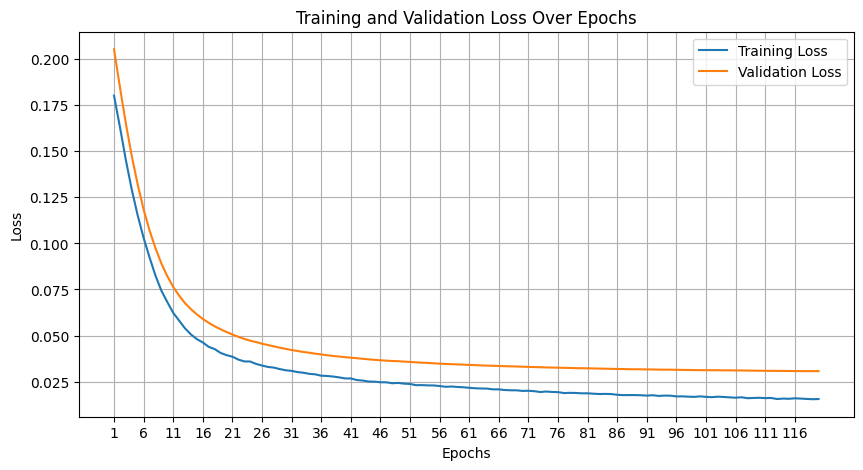

Model weights saved as bert_model_weights.pth


In [18]:
model, training_stats = train(model, train_dataloader, validation_dataloader, optimizer, scheduler, criterion, device, collate_fn, epochs)
save_bert_model(model)

In [19]:
# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display the table
df_stats

,Training Loss,Validation Loss
epoch,,
1,0.180200,0.205397
2,0.163229,0.184819
3,0.145277,0.165114
4,0.129164,0.147414
5,0.115214,0.132002
...,...,...
116,0.015921,0.030704
117,0.015769,0.030680
118,0.015583,0.030656


In [23]:
# load the test set
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")

# Prepare the data
first_sent = [i['sentence1'] for i in test_dataset]
second_sent = [i['sentence2'] for i in test_dataset]
full_text = [[str(x), str(y)] for x,y in zip(first_sent, second_sent)]

model.eval()

def predict_similarity(sentence_pair):
  test_input = tokenizer(sentence_pair, padding='max_length', max_length = 128, truncation=True, return_tensors="pt").to(device)
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']
  output = model(test_input)
  sim = torch.nn.functional.cosine_similarity(output[0], output[1], dim=0).item()
  return sim

In [24]:
example_1 = full_text[100]
print(f"Sentence 1: {example_1[0]}")
print(f"Sentence 2: {example_1[1]}")
print(f"Predicted similarity score: {round(predict_similarity(example_1), 2)}")

Sentence 1: A cat is walking around a house.
Sentence 2: A woman is peeling potato.
Predicted similarity score: 0.03


In [25]:
example_2 = full_text[130]
print(f"Sentence 1: {example_2[0]}")
print(f"Sentence 2: {example_2[1]}")
print(f"Predicted similarity score: {round(predict_similarity(example_2), 2)}")

Sentence 1: Two men are playing football.
Sentence 2: Two men are practicing football.
Predicted similarity score: 0.88


In [26]:
example_3 = full_text[812]
print(f"Sentence 1: {example_3[0]}")
print(f"Sentence 2: {example_3[1]}")
print(f"Predicted similarity score: {round(predict_similarity(example_3), 2)}")

Sentence 1: It varies by the situation.
Sentence 2: This varies by institution.
Predicted similarity score: 0.64


In [30]:
example_4 = full_text[23]
print(f"Sentence 1: {example_4[0]}")
print(f"Sentence 2: {example_4[1]}")
print(f"Predicted similarity score: {round(predict_similarity(example_4), 2)}")

Sentence 1: A man is cutting a potato.
Sentence 2: A man is slicing some potato.
Predicted similarity score: 0.88
